In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt

from importlib import reload

import rea.reconstruct as rec


In [2]:
# folder = './__test__/k__4--nens__999--T__10'
# folder = './__test__/0--k__0--nens__999--T__10'
# folder = './__test__/rv--k__4--nens__999--T__10'
# folder = './__test__/rv--k__4--nens__20--T__10'
# folder = './__test__/0--k__4--nens__100--T__10'
# folder = './__test__/c--k__0--nens__999--T__10'
# folder = './__test__/c--k__0--nens__100--T__10'
# folder = './__test__/f1--k__4--nens__999--T__10'
# folder = './__test__/c0--k__0--nens__999--T__10'
# folder = './__test__/av_f0--k__4--nens__1000--T__50/'
# folder = './__test__/av_c0--k__0--nens__10000--T__1000'

folder = '../veros/__test__/r1_minimal'
# rec_dict = ut.json2dict(f'{folder}/reconstructed.json')

In [20]:
reload(rec)

<module 'reconstruct' from '/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/demo/reconstruct.py'>

In [35]:
rec_dict = rec.reconstruct(f'{folder}/i0020')
# rec_dict = rec.reconstruct(f'{folder}/i0009')

DONE


In [36]:
rec_trajs = {}

for rname, r in tqdm(rec_dict['members'].items()):
    traj = []
    for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
        traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
    traj = np.concatenate(traj)

    rec_trajs[rname] = traj

# observables = {r: traj[-1,1] for r,traj in rec_trajs.items()}
observables = {r: np.mean(traj[-5:,1]) for r,traj in rec_trajs.items()}

  0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
observables = {r: np.load(f'{folder}/i0019/e{i+1:03d}-traj.npy')[-1,1] for i,r in enumerate(observables)}

In [4]:
## get the killed trajectories

nens = len(rec_dict['members'])
enss = set([f'e{i+1:0{len(str(nens))}d}' for i in range(nens)])

killed_trajs = []
for i,f in tqdm(enumerate(rec_dict['folders'])):
    kens = enss - set([r['ancestry'][i] for r in rec_dict['members'].values()])
    killed_trajs.append({ke: np.load(f'{folder}/{f}/{ke}-traj.npy') for ke in kens})

0it [00:00, ?it/s]

## Plot trajectories

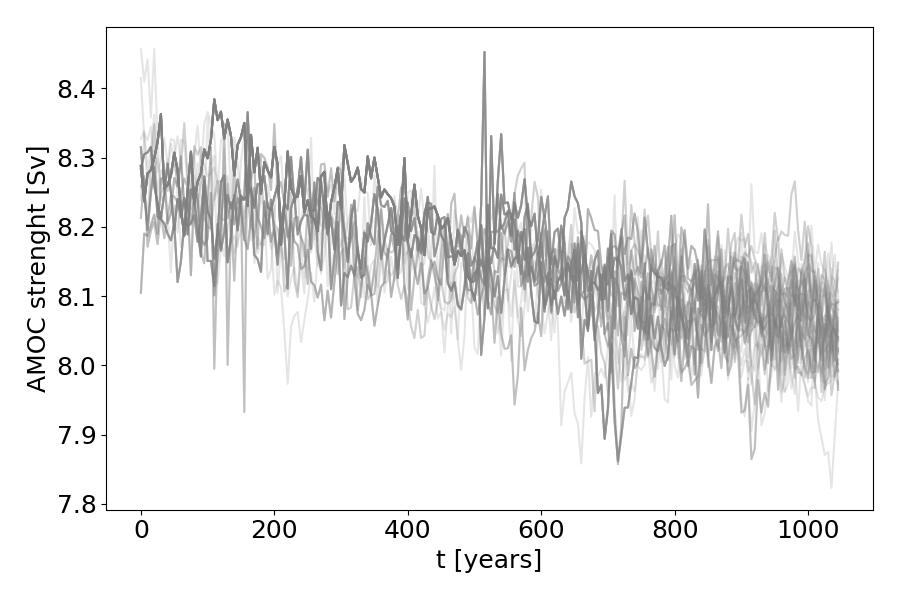

In [27]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

for traj in rec_trajs.values():
    plt.plot(traj[:,0]-traj[0,0], -traj[:,1], color='gray', alpha=0.2)
    
# for seg in killed_trajs:
#     for traj in seg.values():
#         plt.plot(traj[:,0], -traj[:,1], color='red', alpha=0.2)
    
# plt.axhline(0, color='black', linestyle='dashed')

plt.xlabel('t [years]')
plt.ylabel('AMOC strenght [Sv]')
# plt.title('N = 1000, k=0')

fig.tight_layout()

In [8]:
traj.shape

(22, 2)

In [8]:
for e in rec_dict['members'].items():
    print(e)

('r01', {'cum_score': 0.3416871989943524, 'cum_log_escore': 1.3667487959774098, 'ancestry': ['e04', 'e02'], 'weight': 0.9410088280361814})
('r02', {'cum_score': 0.44914919510879253, 'cum_log_escore': 1.7965967804351701, 'ancestry': ['e01', 'e01'], 'weight': 0.6122278619293265})
('r03', {'cum_score': 0.32349612715520537, 'cum_log_escore': 1.2939845086208215, 'ancestry': ['e09', 'e09'], 'weight': 1.0120333546508682})
('r04', {'cum_score': 1.0242626363205671, 'cum_log_escore': 4.0970505452822685, 'ancestry': ['e07', 'e07'], 'weight': 0.06135341119330253})
('r05', {'cum_score': 0.5665726653128091, 'cum_log_escore': 2.2662906612512366, 'ancestry': ['e07', 'e03'], 'weight': 0.3827609549506337})
('r06', {'cum_score': 1.0242626363205671, 'cum_log_escore': 4.0970505452822685, 'ancestry': ['e07', 'e07'], 'weight': 0.06135341119330253})
('r07', {'cum_score': 1.0242626363205671, 'cum_log_escore': 4.0970505452822685, 'ancestry': ['e07', 'e07'], 'weight': 0.06135341119330253})
('r08', {'cum_score': 

In [9]:
# check the scores

In [40]:
first_info = ut.json2dict(f"{folder}/{rec_dict['folders'][0]}/info.json")
last_info = ut.json2dict(f"{folder}/{rec_dict['last_folder']}/info.json")
for rname, e in rec_dict['members'].items():
    ename = rname.replace('r','e')
    
    cum_score = last_info['members'][ename]['cum_score_i'] - first_info['members'][e['ancestry'][0]]['cum_score_i']
    cum_log_escore = last_info['members'][ename]['cum_log_escore_i'] - first_info['members'][e['ancestry'][0]]['cum_log_escore_i']
    print(rname, cum_score - e['cum_score'], cum_log_escore - e['cum_log_escore'])

r01 0.0 0.0
r02 0.0 0.0
r03 0.0 0.0
r04 0.0 1.1102230246251565e-16
r05 0.0 0.0
r06 0.0 0.0
r07 0.0 0.0
r08 0.0 0.0
r09 0.0 0.0
r10 0.0 -1.1102230246251565e-16
r11 0.0 -1.1102230246251565e-16
r12 0.0 0.0
r13 0.0 0.0
r14 0.0 0.0
r15 0.0 0.0
r16 0.0 0.0
r17 0.0 0.0
r18 0.0 0.0
r19 0.0 0.0
r20 0.0 0.0
r21 0.0 0.0
r22 0.0 0.0
r23 0.0 0.0
r24 0.0 0.0
r25 0.0 0.0
r26 0.0 0.0
r27 0.0 0.0
r28 0.0 0.0
r29 0.0 2.220446049250313e-16
r30 0.0 0.0
r31 0.0 0.0
r32 0.0 0.0
r33 0.0 0.0
r34 0.0 0.0
r35 0.0 0.0
r36 0.0 0.0
r37 0.0 0.0
r38 0.0 0.0
r39 0.0 0.0
r40 0.0 0.0
r41 0.0 0.0
r42 0.0 -2.220446049250313e-16
r43 0.0 -2.7755575615628914e-16
r44 0.0 0.0
r45 0.0 0.0
r46 0.0 0.0
r47 0.0 0.0
r48 0.0 0.0
r49 0.0 0.0
r50 0.0 0.0


In [21]:
plt.close('all')

In [73]:
np.min(list(observables.values()))

1.0618594036131523

In [32]:
rec_dict['independent_parents']

[44,
 46,
 48,
 49,
 51,
 52,
 57,
 58,
 64,
 71,
 77,
 82,
 98,
 113,
 134,
 164,
 206,
 269,
 343,
 533]

## Compute expectations

In [37]:
def f(x, a):
    return float(x > a)

def expectation(func, **kwargs):
    _f = np.array([func(x, **kwargs) for x in observables.values()])
    # print(np.mean(_f))
    _w = np.array([r['weight'] for r in rec_dict['members'].values()])
    # print(np.sum(_w))
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean(_f*_w**2)/len(_w))

    return unc.ufloat(mean,std)

In [31]:
min_obs = np.min(list(observables.values()))
max_obs = np.max(list(observables.values()))

In [43]:
expectation(f, a=-8.1)

0.44
63.13235622276003


0.23464777619852703+/-0.0663857427418472

In [32]:
max_obs = -7.5
min_obs = -8.3

In [38]:
a = np.linspace(min_obs, max_obs, 100)
probs = np.array([expectation(f, a=_a) for _a in a])

In [54]:
traj.shape

(100, 2)

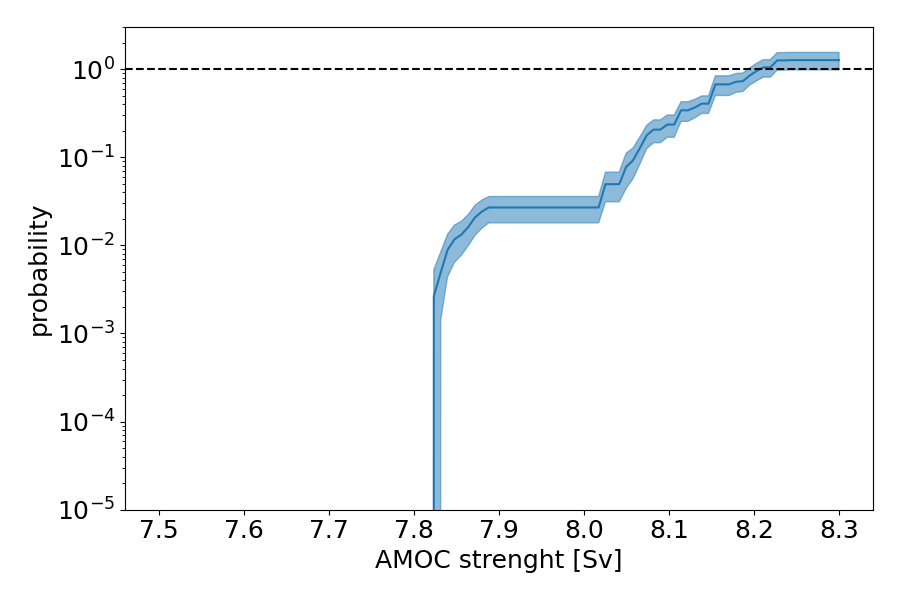

In [34]:
plt.close(3)
fig, ax = plt.subplots(num=3, figsize=(9,6))

uplt.errorband(-a,probs, label=f'After {traj[-1,0]-traj[0,0] + 5:.0f} years')
plt.yscale('log')
plt.ylim(1e-5,3)
plt.axhline(1, color='black', linestyle='dashed')

plt.xlabel('AMOC strenght [Sv]')
plt.ylabel('probability')

# plt.title(f'After {traj[-1,0]-traj[0,0] + 5:.0f} years')

fig.tight_layout()

In [39]:
uplt.errorband(-a,probs, label=f'After {traj[-1,0]-traj[0,0] + 5:.0f} years')

([<matplotlib.lines.Line2D at 0x7f6184535580>],
 None)

In [40]:
plt.legend()

## Theoretical probability of overcoming threshold

In [15]:
lam = 1
sig = 1
def ou_var(t):
    return sig**2/(2*lam)*(1 - np.exp(-2*lam*t))

cum_gaus = lambda x: 0.5*(1 + ss.erf(x/np.sqrt(2)))

overcoming_prob = lambda x,v: cum_gaus(-x/np.sqrt(v))

In [16]:
t = 2
v = ou_var(t)

In [33]:
a = np.linspace(0,4,101)

e = np.array([expectation(f, a=_a) for _a in a])
e_th = overcoming_prob(a,v)

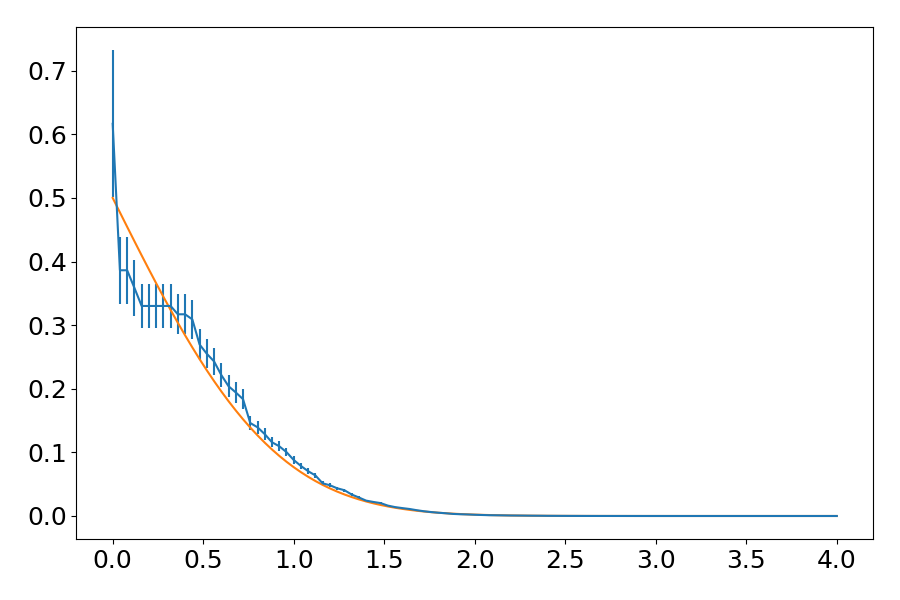

In [34]:
plt.close(2)
fig,ax = plt.subplots(figsize=(9,6))

uplt.plot(a,e)
plt.plot(a, e_th)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))
# plt.plot(a, uplt.nominal_value(e)/e_th - 1)

fig.tight_layout()

In [72]:
uplt.plot(a,e)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))

<ErrorbarContainer object of 3 artists>